In [2]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.Sarimax import Sarimax
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima
from skforecast.ForecasterSarimax import ForecasterSarimax

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

import joblib



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SARIMAX for Luzon
DATA PREPROCESSING

In [4]:
labels_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/train_labels_transformed.csv'
data_csv = r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/train_data_transformed.csv'
test_data_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/test_data.csv'
test_labels_csv=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/test_labels.csv'
transformed_data=r'/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/data_transformed.csv'
luz_complete_data = '/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/LUZ_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

luz_complete_data_df = pd.read_csv(luz_complete_data)
luz_gwap = luz_complete_data_df[['GWAP']]
luz_lwap = luz_complete_data_df[['LWAP']]



In [5]:
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [6]:
#Preparing the dataframes
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)
transformed_train_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)
LUZ_data_columns = ['FLOW_LUZ', 'Hourly Demand', 'TMAX_Cubi Point', 'TMAX_NAIA', 'TMIN_NAIA', 'TMAX_Science Garden', 'TMAX_SanJose', 'TMIN_SanJose', 'TMAX_Tayabas', 'TMIN_Tayabas', 'TMAX_CLSU', 'TMIN_CLSU', 'TMAX_Ambulong', 'TMAX_Casiguran', 'TMIN_Casiguran', 'TMAX_Clark', 'TMIN_Clark', 'TMAX_Calapan', 'TMIN_Calapan', 'GWAP', 'LWAP', 'TMIN_Cubi Point', 'TMIN_Science Garden', 'TMIN_Ambulong', 'RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'RAINFALL_Cubi Point', 'RAINFALL_NAIA', 'RAINFALL_Science Garden', 'RAINFALL_San Jose', 'RAINFALL_Tayabas', 'RAINFALL_CLSU', 'RAINFALL_Tanay', 'TMAX_Tanay', 'TMIN_Tanay', 'RAINFALL_Ambulong', 'RAINFALL_Casiguran', 'RAINFALL_Clark', 'RAINFALL_Calapan']
LUZ_data_train = pd.DataFrame(transformed_train_data)
LUZ_data_test = pd.DataFrame(test_data, columns = LUZ_data_columns)

transformed_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)


In [7]:
#lagging the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Removing GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])

#Preparing the exog datasets
luz_train_exog = transformed_exog[:train_size]
luz_test_exog = transformed_exog[train_size:]



In [35]:
#Preparing transformed GWAP datasets
LUZ_GWAP_train = labels_train['GWAP']
LUZ_GWAP_train = pd.concat([train_date,LUZ_GWAP_train], axis=1)
LUZ_GWAP_train.set_index('Date', inplace=True)
LUZ_GWAP_train.index = pd.to_datetime(LUZ_GWAP_train.index)
LUZ_GWAP_train.index.freq='D'
LUZ_GWAP_train = LUZ_GWAP_train.squeeze()


LUZ_GWAP_test = labels_test['GWAP']
LUZ_GWAP_test = pd.concat([test_date,LUZ_GWAP_test], axis=1)
LUZ_GWAP_test.set_index('Date', inplace=True)
LUZ_GWAP_test.index = pd.to_datetime(LUZ_GWAP_test.index)
LUZ_GWAP_test.index.freq='D'
LUZ_GWAP_test = LUZ_GWAP_test.squeeze()

#Preparing original GWAP datasets
LUZ_GWAP = pd.concat([date_df,luz_gwap], axis=1)
LUZ_GWAP.set_index('Date', inplace=True)
LUZ_GWAP.index = pd.to_datetime(LUZ_GWAP.index)
LUZ_GWAP.index.freq='D'
LUZ_GWAP = LUZ_GWAP.squeeze()

LUZ_GWAP_test_inversed = LUZ_GWAP[train_size:]




#Preparing the transformed LWAP datasets
LUZ_LWAP_train = labels_train['LWAP']
LUZ_LWAP_train = pd.concat([train_date,LUZ_LWAP_train], axis=1)
LUZ_LWAP_train.set_index('Date', inplace=True)
LUZ_LWAP_train.index = pd.to_datetime(LUZ_LWAP_train.index)
LUZ_LWAP_train.index.freq='D'
LUZ_LWAP_train = LUZ_LWAP_train.squeeze()

LUZ_LWAP_test = labels_test['LWAP']
LUZ_LWAP_test = pd.concat([test_date,LUZ_LWAP_test], axis=1)
LUZ_LWAP_test.set_index('Date', inplace=True)
LUZ_LWAP_test.index = pd.to_datetime(LUZ_LWAP_test.index)
LUZ_LWAP_test.index.freq='D'
LUZ_LWAP_test = LUZ_LWAP_test.squeeze()

#Preparing the original LWAP datasets

LUZ_LWAP = pd.concat([date_df,luz_lwap], axis=1)
LUZ_LWAP.set_index('Date', inplace=True)
LUZ_LWAP.index = pd.to_datetime(LUZ_LWAP.index)
LUZ_LWAP.index.freq='D'
LUZ_LWAP = LUZ_LWAP.squeeze()

LUZ_LWAP_test_inversed = LUZ_LWAP[train_size:]



#Preparing the exogenous datasets
LUZ_exog_train = pd.concat([train_date,luz_train_exog], axis=1)
LUZ_exog_train.set_index('Date', inplace=True)

luz_test_exog = pd.DataFrame(luz_test_exog)
luz_test_exog = luz_test_exog.reset_index()
LUZ_exog_test = pd.concat([test_date,luz_test_exog], axis=1)
LUZ_exog_test.set_index('Date', inplace=True)

ValueError: cannot insert level_0, already exists

In [21]:
LUZ_exog_test = LUZ_exog_test.drop(columns=['index','level_0'])

In [32]:
LUZ_LWAP_test_inversed

Date
2023-08-08     8484.446021
2023-08-09     7590.762852
2023-08-10    10617.636920
2023-08-11     8544.909795
2023-08-12     6871.504444
                  ...     
2023-12-27     4136.799477
2023-12-28     3812.075824
2023-12-29     3804.008781
2023-12-30     3403.759761
2023-12-31     3592.529767
Freq: D, Name: LWAP, Length: 146, dtype: float64

In [33]:
#Plotting Train LWAP ang GWAP
# Create the line plot
luz_gwap_plot = px.line(LUZ_GWAP_train, x=LUZ_GWAP_train.index, y='GWAP')
luz_lwap_plot = px.line(LUZ_LWAP_train, x=LUZ_LWAP_train.index, y='LWAP')
# Set the title using the ticker value
luz_gwap_plot.update_layout(title=f"Luzon GWAP")
luz_lwap_plot.update_layout(title=f"Luzon LWAP")
# Display the plot
luz_gwap_plot.show()
luz_lwap_plot.show()

In [24]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [25]:
#Checking for stationarity in GWAP data
perform_differencing(LUZ_GWAP_train)
perform_differencing(LUZ_LWAP_train)



Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')


Date
2022-01-01    0.258105
2022-01-02    0.314556
2022-01-03    0.418724
2022-01-04    0.501099
2022-01-05    0.787813
                ...   
2023-08-03    0.317026
2023-08-04    0.432209
2023-08-05    0.410919
2023-08-06    0.415499
2023-08-07    0.426566
Freq: D, Name: LWAP, Length: 584, dtype: float64

In [45]:
LUZ_diff_exog_train = perform_df_differencing(LUZ_exog_train)
LUZ_diff_exog_train = LUZ_diff_exog_train.fillna(0)

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is out

Column 'FLOW_LUZ' is stationary after differencing 0 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 0 times.
Column 'TMAX_NAIA' is stationary after differencing 0 times.
Column 'TMIN_NAIA' is stationary after differencing 0 times.
Column 'TMAX_Science Garden' is stationary after differencing 0 times.
Column 'TMAX_SanJose' is stationary after differencing 0 times.
Column 'TMIN_SanJose' is stationary after differencing 1 times.
Column 'TMAX_Tayabas' is stationary after differencing 0 times.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is out

Column 'TMIN_Tayabas' is stationary after differencing 1 times.
Column 'TMAX_CLSU' is stationary after differencing 1 times.
Column 'TMIN_CLSU' is stationary after differencing 1 times.
Column 'TMAX_Ambulong' is stationary after differencing 0 times.
Column 'TMAX_Casiguran' is stationary after differencing 1 times.
Column 'TMIN_Casiguran' is stationary after differencing 1 times.
Column 'TMAX_Clark' is stationary after differencing 0 times.
Column 'TMIN_Clark' is stationary after differencing 0 times.
Column 'TMAX_Calapan' is stationary after differencing 0 times.
Column 'TMIN_Calapan' is stationary after differencing 1 times.
Column 'TMIN_Cubi Point' is stationary after differencing 0 times.


/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is out

Column 'TMIN_Science Garden' is stationary after differencing 1 times.
Column 'TMIN_Ambulong' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 0 times.
Column 'RESERVE_GWAP_Ru' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Cubi Point' is stationary after differencing 1 times.
Column 'RAINFALL_NAIA' is stationary after differencing 0 times.
Column 'RAINFALL_Science Garden' is stationary after differencing 0 times.
Column 'RAINFALL_San Jose' is stationary after differencing 0 times.
Column 'RAINFALL_Tayabas' is stationary after differencing 0 times.
Column 'RAINFALL_CLSU' is stationary after differencing 1 times.
Column 'RAINFALL_Tanay' is stationary after differencing 0 times.
Column 'TMAX_Tanay' is stationary after differencing 0 times.
Column 'TMIN_Tanay' is stationary after differencing 1 

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is out

In [28]:
LUZ_diff_exog_train = pd.concat([train_date,LUZ_diff_exog_train], axis=1)
LUZ_diff_exog_train.set_index('Date', inplace=True)

In [57]:
LUZ_diff_exog_test = perform_df_differencing(LUZ_exog_test)
LUZ_diff_exog_test = LUZ_diff_exog_test.fillna(0)


Column 'FLOW_LUZ' is stationary after differencing 1 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 1 times.
Column 'TMAX_NAIA' is stationary after differencing 0 times.
Column 'TMIN_NAIA' is stationary after differencing 1 times.
Column 'TMAX_Science Garden' is stationary after differencing 0 times.
Column 'TMAX_SanJose' is stationary after differencing 1 times.
Column 'TMIN_SanJose' is stationary after differencing 1 times.
Column 'TMAX_Tayabas' is stationary after differencing 1 times.
Column 'TMIN_Tayabas' is stationary after differencing 0 times.
Column 'TMAX_CLSU' is stationary after differencing 0 times.
Column 'TMIN_CLSU' is stationary after differencing 1 times.
Column 'TMAX_Ambulong' is stationary after differencing 1 times.
Column 'TMAX_Casiguran' is stationary after differencing 1 times.
Column 'TMIN_Casiguran' is stationary after differencing 1 times.
Column 'TMAX_Clark' is stationary after 

/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c')
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/2411308064.py:37: InterpolationWarning: The test statistic is out

In [58]:
LUZ_exog_test

,FLOW_LUZ,Hourly Demand,TMAX_Cubi Point,TMAX_NAIA,TMIN_NAIA,TMAX_Science Garden,TMAX_SanJose,TMIN_SanJose,TMAX_Tayabas,TMIN_Tayabas,...,RAINFALL_San Jose,RAINFALL_Tayabas,RAINFALL_CLSU,RAINFALL_Tanay,TMAX_Tanay,TMIN_Tanay,RAINFALL_Ambulong,RAINFALL_Casiguran,RAINFALL_Clark,RAINFALL_Calapan
Date,,,,,,,,,,,,,,,,,,,,,
2023-08-08,0.690517,0.806836,0.414414,0.568966,0.629213,0.470588,0.583333,0.974576,0.669355,0.689189,...,0.677802,0.000000,0.833793,0.614640,0.663125,0.565568,0.462262,0.394799,0.000000,0.460690
2023-08-09,0.695289,0.883561,0.414414,0.517241,0.797753,0.519608,0.641667,0.813559,0.838710,0.594595,...,0.449920,0.227910,0.878553,0.589025,0.651086,0.690540,0.419737,0.719360,0.403510,0.460690
2023-08-10,0.679785,0.926719,0.585586,0.577586,0.887640,0.725490,0.458333,0.915254,0.983871,0.486486,...,0.555531,0.227910,0.504053,0.576554,0.804281,0.701798,0.419737,0.394799,0.403510,0.460690
2023-08-11,0.506724,0.928849,0.630631,0.603448,0.820225,0.686275,0.566667,0.711864,0.951613,0.567568,...,0.845524,0.227910,0.901970,0.584586,0.804281,0.701798,0.419737,0.394799,0.506818,0.460690
2023-08-12,0.513207,0.917999,0.513514,0.551724,0.752809,0.647059,0.625000,0.661017,1.000000,0.837838,...,0.872042,0.227910,0.479391,0.581746,0.751083,0.625759,0.419737,0.869509,0.403510,0.460690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,0.491802,0.361942,0.576577,0.422414,0.505618,0.254902,0.791667,0.915254,0.354839,0.486486,...,0.407887,0.707838,0.479391,0.579303,0.521909,0.483418,0.524089,0.954932,0.403510,0.810222
2023-12-28,0.544347,0.531389,0.666667,0.517241,0.539326,0.431373,0.850000,0.957627,0.483871,0.432432,...,0.407887,0.692619,0.479391,0.583723,0.633273,0.500859,0.639387,0.920120,0.403510,0.460690
2023-12-29,0.579528,0.564568,0.612613,0.543103,0.483146,0.460784,0.883333,0.661017,0.516129,0.459459,...,0.407887,0.678458,0.479391,0.575455,0.621560,0.458101,0.691453,0.539452,0.403510,0.460690


In [ ]:
#Checking GWAP for seasonality
from scipy.stats import kruskal

LUZ_GWAP_train_weekly=pd.DataFrame(LUZ_GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LUZ_GWAP_train_weekly['day_of_week'] = LUZ_GWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_GWAP_train_weekly = [group['GWAP'].values for name, group in LUZ_GWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_GWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

In [ ]:
#Checking LWAP for seasonality
LUZ_LWAP_train_weekly=pd.DataFrame(LUZ_GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LUZ_LWAP_train_weekly['day_of_week'] = LUZ_LWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_LWAP_train_weekly = [group['GWAP'].values for name, group in LUZ_LWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_LWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

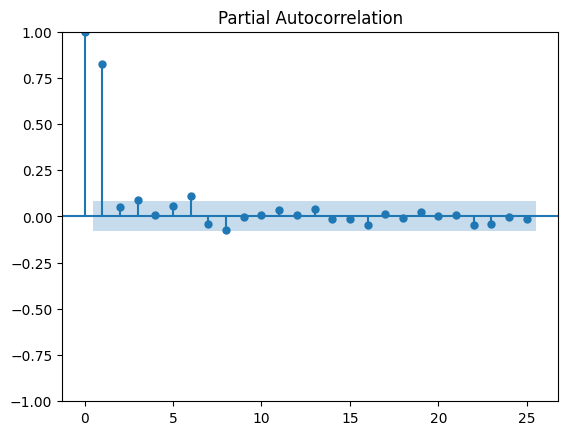

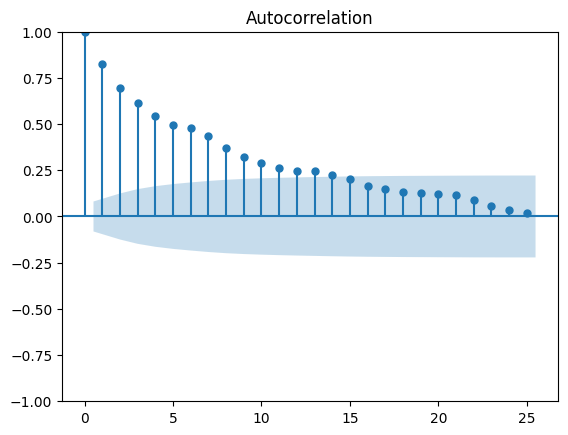

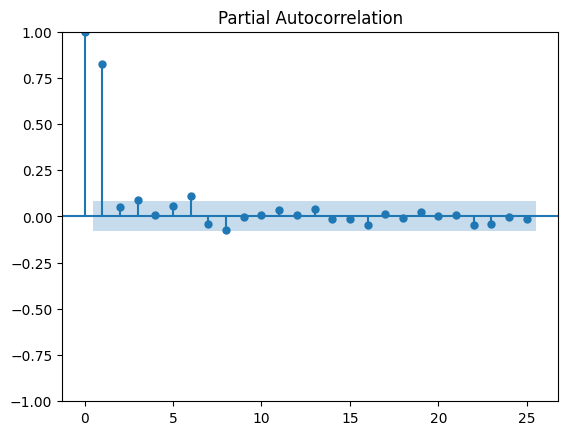

In [37]:
# Visualize autocorrelation using plot_acf
plot_acf(LUZ_GWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LUZ_GWAP_train, lags=25, alpha=0.05)

In [ ]:
#LUZON LWAP
# Visualize autocorrelation using plot_acf
plot_acf(LUZ_LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LUZ_LWAP_train, lags=25, alpha=0.05)

In [ ]:
Skforecast forecasting - no seasonality

In [38]:
#PACF for GWAP cuts off at lag 1; ACF for GWAP cuts off at lag 13
#Auto-Arima: Identification of best orders using AIC
LUZ_GWAP_sarimax = auto_arima(LUZ_GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=13,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=True,
                            exog=LUZ_diff_exog)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1019.602, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1028.298, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1033.009, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1021.597, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1065.384, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1064.312, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1048.248, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-1067.240, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-1035.004, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-1030.293, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-1066.236, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-1050.245, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.484 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,GWAP
2023-08-08,0.577767
2023-08-09,0.585962
2023-08-10,0.631931
2023-08-11,0.603748
2023-08-12,0.548796
2023-08-13,0.588828
2023-08-14,0.600947
2023-08-15,0.564332
2023-08-16,0.602111
2023-08-17,0.598276


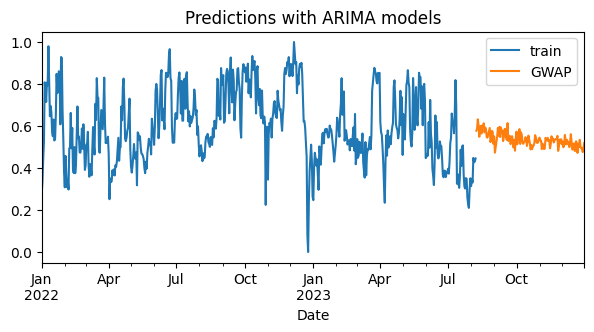

In [39]:
#Using skforecast
luz_gwap_model = Sarimax(order=(1, 1, 1), sm_predict_kwargs={'dynamic': True})
luz_gwap_model.fit(y=LUZ_GWAP_train, exog= LUZ_diff_exog)
luz_gwap_model.summary()

# Prediction
# ==============================================================================
luz_gwap_predictions = luz_gwap_model.predict(steps=len(LUZ_GWAP_test), exog=luz_test_exog)
luz_gwap_predictions.columns = ['GWAP']
display(luz_gwap_predictions.head(10))

#Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
LUZ_GWAP_train.plot(ax=ax, label='train')
luz_gwap_predictions.plot(ax=ax, label='Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()


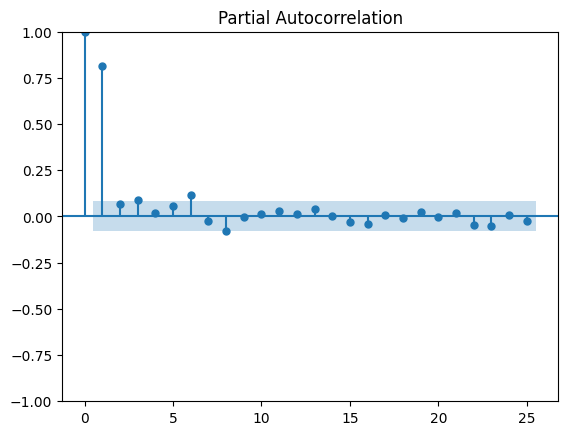

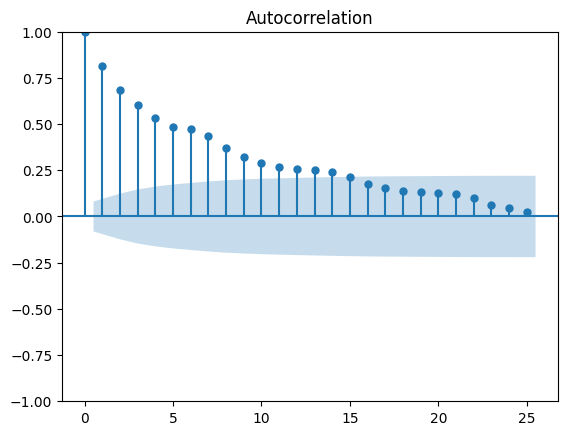

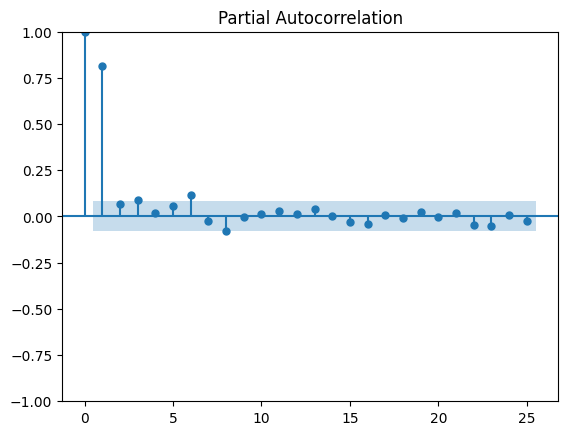

In [40]:
#LUZON LWAP
# Visualize autocorrelation using plot_acf
plot_acf(LUZ_LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LUZ_LWAP_train, lags=25, alpha=0.05)

In [41]:
#PACF for LWAP cuts off at lag 1; ACF for LWAP cuts off at lag 14
#Auto-Arima: Identification of best orders using AIC
LUZ_LWAP_sarimax = auto_arima(LUZ_LWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=14, 
                            seasonal=False,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=LUZ_diff_exog, iter=1000)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-975.031, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-993.443, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-1009.065, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1010.857, Time=0.13 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1013.558, Time=0.26 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-1018.611, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-987.165, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1025.669, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1022.154, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1017.876, Time=0.30 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-1017.165, Time=0.45 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 2.292 seconds


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



,LWAP
2023-08-08,0.552705
2023-08-09,0.566166
2023-08-10,0.613101
2023-08-11,0.578702
2023-08-12,0.520908
2023-08-13,0.564401
2023-08-14,0.573788
2023-08-15,0.535754
2023-08-16,0.571757
2023-08-17,0.563150


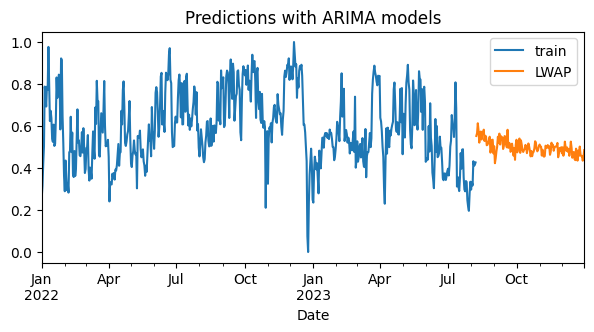

In [42]:
#Using skforecast
luz_model_lwap = Sarimax(order=(1, 1, 1), sm_predict_kwargs={'dynamic': True})
luz_model_lwap.fit(y=LUZ_LWAP_train, exog= LUZ_diff_exog)
luz_model_lwap.summary()

# Prediction
# ==============================================================================
luz_lwap_predictions = luz_model_lwap.predict(steps=len(LUZ_LWAP_test), exog=luz_test_exog)
luz_lwap_predictions.columns = ['LWAP']
display(luz_lwap_predictions.head(10))

#Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
LUZ_LWAP_train.plot(ax=ax, label='train')
luz_lwap_predictions.plot(ax=ax, label='LWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()


In [43]:
#Applying the inverse transformations
#Loading inverse transformations for Luzon

luz_minmax_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/minmax_scaler.pkl')
luz_boxcox_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/boxcox_pipeline.pkl')
luz_yeojohnson_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/yeojohnson_pipeline.pkl')
luz_boxcoxy_fit_loaded = joblib.load('/Users/jojielyn/Desktop/School/04 Senior/Thesis/SARIMAX/Luzon/boxcox_pipeliney.pkl')

In [44]:
luz_predictions = pd.concat([luz_gwap_predictions, luz_lwap_predictions], axis=1)
luz_predictions_inverse=luz_boxcoxy_fit_loaded.inverse_transform(luz_predictions)
luz_predictions_inverse

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[7331.84379731, 7548.69556079],
       [7535.76308032, 7897.82645719],
       [8841.38491056, 9299.98080465],
       [8006.64192499, 8242.81835667],
       [6669.82102714, 6802.53619208],
       [7608.98755851, 7850.83603287],
       [7929.78791622, 8105.19774247],
       [7013.88064658, 7137.93924869],
       [7961.60682674, 8049.23056074],
       [7857.47916947, 7817.7333354 ],
       [8267.86040201, 8354.52359318],
       [7144.0774156 , 6975.36134317],
       [7719.16005398, 7577.06732639],
       [7456.86489079, 7485.03941377],
       [6625.78243336, 6537.98532063],
       [6582.74089749, 6580.81209568],
       [6928.10995974, 6779.46550345],
       [7308.06533866, 7130.64679755],
       [7653.97489554, 7455.89099789],
       [6159.81517151, 5860.81314163],
       [6423.16223171, 6224.68900336],
       [7314.89908338, 7096.89191403],
       [7195.31610404, 7119.94590844],
       [6002.16482999, 5795.43882578],
       [6709.0078273 , 6440.74086135],
       [5293.96377685, 50

In [45]:
luz_predictions_inverse_df = pd.DataFrame(luz_predictions_inverse)
luz_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

LUZ_GWAP_predictions_inverse = pd.DataFrame(luz_predictions_inverse[:, 0], columns=['GWAP'])
LUZ_GWAP_predictions_inverse = pd.concat([test_date,LUZ_GWAP_predictions_inverse], axis=1)
LUZ_GWAP_predictions_inverse.set_index('Date', inplace=True)
LUZ_GWAP_predictions_inverse.index = pd.to_datetime(LUZ_GWAP_predictions_inverse.index)
LUZ_GWAP_predictions_inverse.index.freq='D'
LUZ_GWAP_predictions_inverse = LUZ_GWAP_predictions_inverse.squeeze()

LUZ_LWAP_predictions_inverse = pd.DataFrame(luz_predictions_inverse[:, 0], columns=['LWAP'])
LUZ_LWAP_predictions_inverse = pd.concat([test_date,LUZ_LWAP_predictions_inverse], axis=1)
LUZ_LWAP_predictions_inverse.set_index('Date', inplace=True)
LUZ_LWAP_predictions_inverse.index = pd.to_datetime(LUZ_LWAP_predictions_inverse.index)
LUZ_LWAP_predictions_inverse.index.freq='D'
LUZ_LWAP_predictions_inverse = LUZ_LWAP_predictions_inverse.squeeze()




Mean Absolute Error (MAE) on Test Set: 2213.73565439138
Root Mean Squared Error (RMSE) on Test Set: 3058.281696830567


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



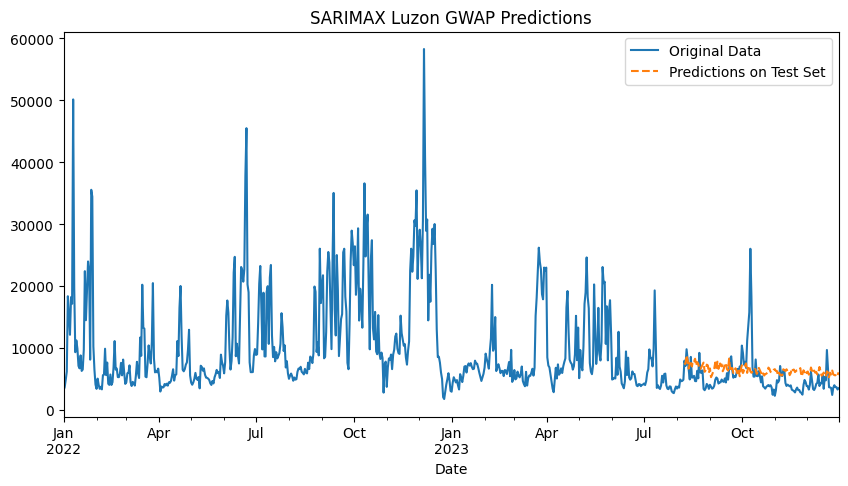

In [46]:
# Calculate MAE for the Luzon GWAP test set
mae_test = mean_absolute_error(LUZ_GWAP_test_inversed, LUZ_GWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate MSE for the Luzon GWAP test set
rmse_test = mean_squared_error(LUZ_GWAP_test_inversed, LUZ_GWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LUZ_GWAP.plot(ax=ax, label='Original Data')
LUZ_GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon GWAP Predictions')
ax.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Mean Absolute Error (MAE) on Test Set: 2162.658905253045
Root Mean Squared Error (RMSE) on Test Set: 3142.907555775248


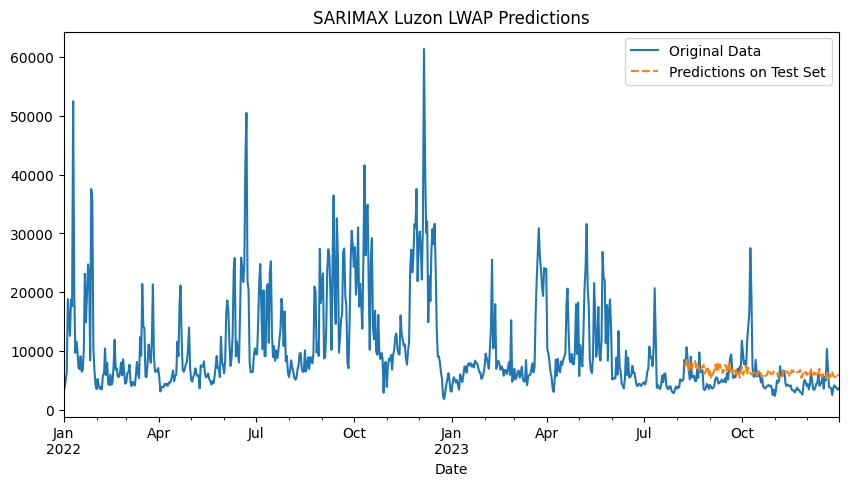

In [47]:
# Calculate MAE for the Luzon LWAP test set
mae_test = mean_absolute_error(LUZ_LWAP_test_inversed, LUZ_LWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate MSE for the Luzon LWAP test set
rmse_test = mean_squared_error(LUZ_LWAP_test_inversed, LUZ_LWAP_predictions_inverse, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LUZ_LWAP.plot(ax=ax, label='Original Data')
LUZ_LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon LWAP Predictions')
ax.legend()
plt.show()

Statsmodels forecasting - normal

In [87]:
#weekly seasonality
LUZ_GWAP_sarimax_7 = auto_arima(LUZ_GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=14, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=LUZ_diff_exog, iter=1000, method='bfgs')

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1019.602, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-1020.747, Time=0.30 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-1018.783, Time=0.68 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-1020.800, Time=0.22 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.28 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-1017.465, Time=3.13 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-1018.846, Time=0.44 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-1017.184, Time=1.77 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.80 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1033.009, Time=0.09 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1034.434, Time=0.17 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1032.617, Time=1.31 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1034.567, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-1031.891, Time=2.53 sec
 ARIMA(0,1,1)

In [49]:
from scipy.stats import kruskal

In [51]:
LUZ_GWAP_train_weekly=pd.DataFrame(LUZ_GWAP_train)

In [52]:

from scipy.stats import kruskal

LUZ_GWAP_train_weekly=pd.DataFrame(LUZ_GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LUZ_GWAP_train_weekly['day_of_week'] = LUZ_GWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_GWAP_train_weekly = [group['GWAP'].values for name, group in LUZ_GWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_GWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 13.75404219114398
p-value: 0.03250762899891647
There are significant differences between the weekly groups.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.994754
         Iterations: 43
         Function evaluations: 48
         Gradient evaluations: 48


,GWAP
2023-08-08,0.578523
2023-08-09,0.600862
2023-08-10,0.653149
2023-08-11,0.636189
2023-08-12,0.585313
2023-08-13,0.623399
2023-08-14,0.641937
2023-08-15,0.608092
2023-08-16,0.644609
2023-08-17,0.642403


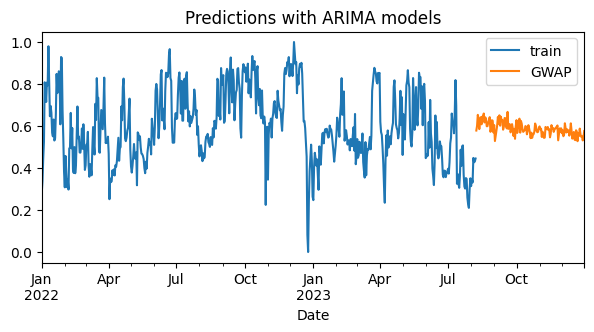

In [112]:
#Using skforecast
luz_gwap_model_weekly = Sarimax(order=(1, 1, 1), seasonal_order=(1,0,0,7),  sm_predict_kwargs={'dynamic': True}, method='bfgs', disp=True)
luz_gwap_model_weekly.fit(y=LUZ_GWAP_train, exog= LUZ_diff_exog)
luz_gwap_model_weekly.summary()

# Prediction
# ==============================================================================
luz_gwap_predictions_weekly = luz_gwap_model_weekly.predict(steps=len(LUZ_GWAP_test), exog=luz_test_exog)
luz_gwap_predictions_weekly.columns = ['GWAP']
display(luz_gwap_predictions_weekly.head(10))

#Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
LUZ_GWAP_train.plot(ax=ax, label='train')
luz_gwap_predictions_weekly.plot(ax=ax, label='Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [47]:
#Using statsmodels

luz_gwap_model_weekly = SARIMAX(endog = LUZ_GWAP_train, exog = LUZ_diff_exog_train, order=(1, 1, 1), seasonal_order=(1,0,0,7),  method='bfgs')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [48]:
fitted_luz_gwap_model_weekly=luz_gwap_model_weekly.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           43     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.76774D-01    |proj g|=  9.75588D-02

At iterate    5    f= -9.79356D-01    |proj g|=  5.07504D-02

At iterate   10    f= -9.83648D-01    |proj g|=  3.57136D-02

At iterate   15    f= -9.84307D-01    |proj g|=  5.81592D-03

At iterate   20    f= -9.84404D-01    |proj g|=  4.78089D-03

At iterate   25    f= -9.84519D-01    |proj g|=  9.93578D-03

At iterate   30    f= -9.84928D-01    |proj g|=  8.84529D-02

At iterate   35    f= -9.86377D-01    |proj g|=  1.33027D-01

At iterate   40    f= -9.88552D-01    |proj g|=  9.87195D-02

At iterate   45    f= -9.90560D-01    |proj g|=  2.58947D-02

At iterate   50    f= -9.91625D-01    |proj g|=  2.33632D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [49]:
gwap_train_predict = fitted_luz_gwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=LUZ_diff_exog_train)


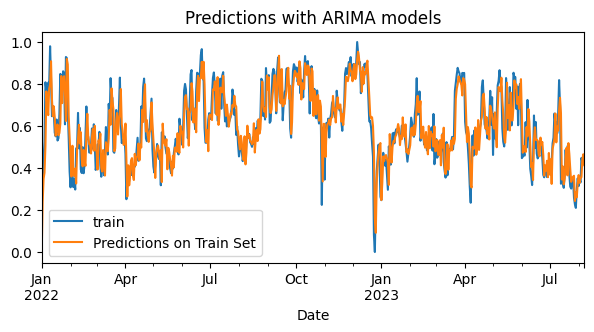

In [51]:
fig, ax = plt.subplots(figsize=(7, 3))
LUZ_GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


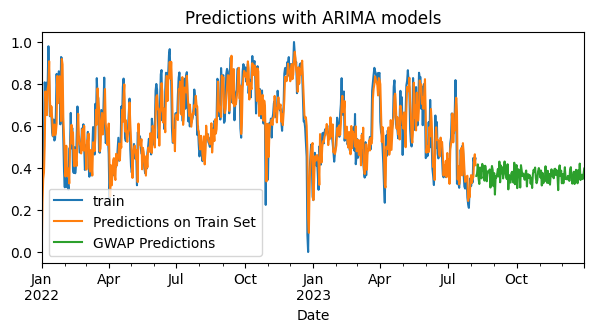

In [68]:
gwap_test_predict = fitted_luz_gwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=LUZ_diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
LUZ_GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [ ]:
luz_lwap_model_weekly = SARIMAX(endog = LUZ_LWAP_train, exog = LUZ_diff_exog_train, order=(1, 1, 1), seasonal_order=(1,0,2,7),  method='bfgs')
fitted_luz_lwap_model_weekly=luz_lwap_model_weekly.fit()
#Check fit on train set
lwap_train_predict = fitted_luz_lwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=LUZ_diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
LUZ_GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [ ]:
#Predict using LWAP mdodel and plot predictions
gwap_test_predict = fitted_luz_gwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=LUZ_diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
LUZ_GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

Rolling Forecast

In [75]:

def rolling_forecast(train, test, exog_train, exog_test, order, season):
    """
    Perform rolling forecast with SARIMAX model, including exogenous variables.
    
    Parameters:
    - train: Series or DataFrame containing the target variable for training.
    - test: Series or DataFrame containing the target variable for testing.
    - exog_train: DataFrame containing the exogenous variables for training.
    - exog_test: DataFrame containing the exogenous variables for testing.
    - order: Tuple (p, d, q) representing the AR, I, and MA terms.
    - season: Tuple (P, D, Q, S) representing the seasonal AR, I, and MA terms with the seasonal period.
    
    Returns:
    - results: Dictionary containing predictions, mse, rmse, and mae.
    """
    history = [x for x in train]  # Start with training data
    exog_history = exog_train.iloc[0:len(train)]  # Corresponding exogenous data for training
    model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
    model_fit = model.fit(disp=False)
    
    predictions = []
    results = {}
    
    # First forecast (out of sample) using the first test point
    exog_forecast = exog_test.iloc[0:1]  # First test point's exogenous variables
    yhat = model_fit.forecast(exog=exog_forecast)[0]
    
    predictions.append(yhat)
    history.append(test[0])  # Add the first test observation to the history
    exog_history = pd.concat([exog_history, exog_test.iloc[0:1]])  # Use concat instead of append
    
    # Rolling forecast loop
    for i in range(1, len(test)):
        model = SARIMAX(history, exog=exog_history, order=order, seasonal_order=season)
        model_fit = model.fit(disp=False)
        
        exog_forecast = exog_test.iloc[i:i+1]  # Current test point exogenous variables
        yhat = model_fit.forecast(exog=exog_forecast)[0]
        
        predictions.append(yhat)
        
        obs = test[i]  # Actual test value
        history.append(obs)  # Append to history
        
        # Concatenate new exogenous data with history
        exog_history = pd.concat([exog_history, exog_test.iloc[i:i+1]])  # Use concat instead of append
    
    # Calculate error metrics
    rmse = mean_squared_error(test, predictions,squared=False)
    mae = mean_absolute_error(test, predictions)
    
    # Convert predictions to a pandas Series
    predictions = pd.Series(predictions, index=test.index)
    
    # Store results
    results['predictions'] = predictions
    results['rmse'] = rmse
    results['mae'] = mae
    
    return results

In [76]:
gwap_rolling_predictions = rolling_forecast(LUZ_GWAP_train, LUZ_GWAP_test, LUZ_diff_exog_train, LUZ_diff_exog_test, order=(1, 1, 1), season=(1,0,0,7))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/r2/vst9rfjd3ps2_vb675mrrrrw0000gn/T/ipykernel_64287/3192779943.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame b

In [55]:
LUZ_LWAP_train_weekly=pd.DataFrame(LUZ_GWAP_train)

In [56]:
LUZ_LWAP_train_weekly=pd.DataFrame(LUZ_GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LUZ_LWAP_train_weekly['day_of_week'] = LUZ_LWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_LWAP_train_weekly = [group['GWAP'].values for name, group in LUZ_LWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_LWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 13.75404219114398
p-value: 0.03250762899891647
There are significant differences between the weekly groups.


In [95]:
LUZ_LWAP_sarimax_7 = auto_arima(LUZ_LWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=14, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=LUZ_diff_exog, iter=1000, method='bfgs')

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-975.031, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-976.667, Time=0.28 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-975.102, Time=0.82 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-976.879, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-974.725, Time=2.26 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-975.386, Time=0.39 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-974.120, Time=2.68 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.91 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-993.443, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-995.365, Time=0.24 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-994.136, Time=1.19 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-995.674, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-994.366, Time=3.03 sec
 ARIMA(0,1,1)(2,0,0)[7] i

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning:

Desired error not necessarily achieved due to precision loss.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



         Current function value: -0.963983
         Iterations: 43
         Function evaluations: 105
         Gradient evaluations: 93


,LWAP
2023-08-08,0.566025
2023-08-09,0.586492
2023-08-10,0.638877
2023-08-11,0.618069
2023-08-12,0.563230
2023-08-13,0.607933
2023-08-14,0.625173
2023-08-15,0.588722
2023-08-16,0.623733
2023-08-17,0.617797


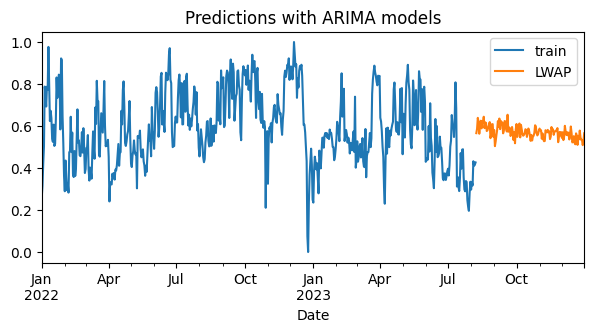

In [105]:
#LWAP
#Using skforecast
luz_lwap_model_weekly = Sarimax(order=(1, 1, 1), seasonal_order=(1,0,2,7),  sm_predict_kwargs={'dynamic': True}, method='bfgs', disp=True)
luz_lwap_model_weekly.fit(y=LUZ_LWAP_train, exog= LUZ_diff_exog)
luz_lwap_model_weekly.summary()

# Prediction
# ==============================================================================
luz_lwap_predictions_weekly = luz_lwap_model_weekly.predict(steps=len(LUZ_LWAP_test), exog=luz_test_exog)
luz_lwap_predictions_weekly.columns = ['LWAP']
display(luz_lwap_predictions_weekly.head(10))

#Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
LUZ_LWAP_train.plot(ax=ax, label='train')
luz_lwap_predictions_weekly.plot(ax=ax, label='Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [109]:
display(luz_lwap_predictions_weekly.tail(10))

,LWAP
2023-12-22,0.510317
2023-12-23,0.552847
2023-12-24,0.536576
2023-12-25,0.578221
2023-12-26,0.545227
2023-12-27,0.533933
2023-12-28,0.533845
2023-12-29,0.509009
2023-12-30,0.529973
2023-12-31,0.565504


In [113]:
luz_predictions_weekly = pd.concat([gwap_test_predict, luz_lwap_predictions_weekly], axis=1)
luz_predictions_inverse_weekly=luz_boxcoxy_fit_loaded.inverse_transform(luz_predictions_weekly)
luz_predictions_inverse_weekly

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[ 7350.31580041,  7894.06760186],
       [ 7927.484738  ,  8467.45263006],
       [ 9552.58469353, 10214.98585921],
       [ 8978.01369899,  9467.48164432],
       [ 7519.33193691,  7819.850965  ],
       [ 8576.28483143,  9129.94256236],
       [ 9167.17827311,  9714.16907283],
       [ 8127.88977355,  8533.2795918 ],
       [ 9257.03920528,  9663.46504053],
       [ 9182.77540052,  9458.23330029],
       [ 9780.03874652, 10418.42314553],
       [ 8382.99691383,  8571.67380556],
       [ 9150.82998475,  9438.77170518],
       [ 8907.08992615,  9351.06798021],
       [ 7874.715913  ,  8173.55146784],
       [ 7887.07732845,  8258.47531015],
       [ 8373.57440749,  8669.77044681],
       [ 8728.64083649,  9059.62601133],
       [ 9174.34913562,  9485.05013222],
       [ 7203.15406233,  7289.74914398],
       [ 7583.92084037,  7792.22726779],
       [ 8704.98342088,  9154.44439751],
       [ 8633.44493335,  9162.03328484],
       [ 7130.30711873,  7436.09804541],
       [ 8030.80

In [114]:
luz_predictions_inverse_weekly_df = pd.DataFrame(luz_predictions_inverse_weekly)
luz_predictions_inverse_weekly_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

LUZ_GWAP_predictions_inverse_weekly = pd.DataFrame(luz_predictions_inverse_weekly[:, 0], columns=['GWAP'])
LUZ_GWAP_predictions_inverse_weekly = pd.concat([test_date,LUZ_GWAP_predictions_inverse_weekly], axis=1)
LUZ_GWAP_predictions_inverse_weekly.set_index('Date', inplace=True)
LUZ_GWAP_predictions_inverse_weekly.index = pd.to_datetime(LUZ_GWAP_predictions_inverse_weekly.index)
LUZ_GWAP_predictions_inverse_weekly.index.freq='D'
LUZ_GWAP_predictions_inverse_weekly = LUZ_GWAP_predictions_inverse_weekly.squeeze()

LUZ_LWAP_predictions_inverse_weekly = pd.DataFrame(luz_predictions_inverse_weekly[:, 0], columns=['LWAP'])
LUZ_LWAP_predictions_inverse_weekly = pd.concat([test_date,LUZ_LWAP_predictions_inverse_weekly], axis=1)
LUZ_LWAP_predictions_inverse_weekly.set_index('Date', inplace=True)
LUZ_LWAP_predictions_inverse_weekly.index = pd.to_datetime(LUZ_LWAP_predictions_inverse_weekly.index)
LUZ_LWAP_predictions_inverse_weekly.index.freq='D'
LUZ_LWAP_predictions_inverse_weekly = LUZ_LWAP_predictions_inverse_weekly.squeeze()


Mean Absolute Error (MAE) on Test Set: 3090.552060211945
Root Mean Squared Error (RMSE) on Test Set: 3677.1117211879045


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



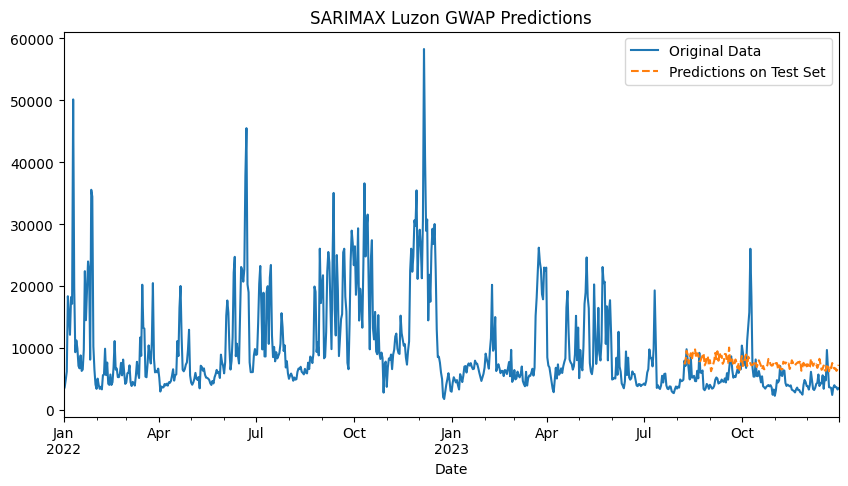

In [115]:
# Calculate MAE for the Luzon GWAP test set
mae_test = mean_absolute_error(LUZ_GWAP_test_inversed, LUZ_GWAP_predictions_inverse_weekly)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate MSE for the Luzon GWAP test set
rmse_test = mean_squared_error(LUZ_GWAP_test_inversed, LUZ_GWAP_predictions_inverse_weekly, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LUZ_GWAP.plot(ax=ax, label='Original Data')
LUZ_GWAP_predictions_inverse_weekly.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon GWAP Predictions')
ax.legend()
plt.show()

Mean Absolute Error (MAE) on Test Set: 2979.6659483069598
Root Mean Squared Error (RMSE) on Test Set: 3661.296157047796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



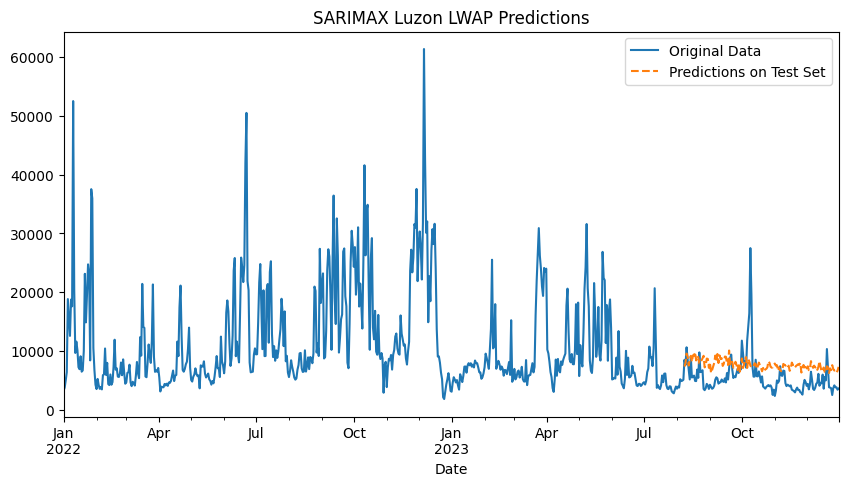

In [117]:
# Calculate MAE for the Luzon LWAP test set
mae_test = mean_absolute_error(LUZ_LWAP_test_inversed, LUZ_LWAP_predictions_inverse_weekly)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate MSE for the Luzon LWAP test set
rmse_test = mean_squared_error(LUZ_LWAP_test_inversed, LUZ_LWAP_predictions_inverse_weekly, squared=False)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LUZ_LWAP.plot(ax=ax, label='Original Data')
LUZ_LWAP_predictions_inverse_weekly.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon LWAP Predictions')
ax.legend()
plt.show()

In [118]:
LUZ_GWAP_arima_7 = auto_arima(LUZ_GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=14, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=LUZ_diff_exog, iter=1000, method='bfgs')

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1019.602, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-1020.747, Time=0.31 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-1018.783, Time=0.69 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-1020.800, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-1017.465, Time=2.91 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-1018.846, Time=0.31 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-1017.184, Time=1.97 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1033.009, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1034.434, Time=0.23 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1032.617, Time=1.02 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1034.567, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.81 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-1031.891, Time=2.75 sec
 ARIMA(0,1,1)